**Brief Overview:**

* For this project, I am supposed to be an ML Engineer/Data Scientist that was tasked to provide a model for predicting housing prices given a set of features (i.e., bedrooms, number of bathrooms, floor area, and land area)
* My approach was to perform a streamlined process of performing model training and hyperparameter optimization so I can look at the MSE and distribution of target and predicted values of each model to determine which is the best.
* The models that I chose for this project from scikit-learn are the following: SVR, MLPRegressor, RandomForestRegressor
* Note: No feature selection was performed. I am planning to do a fit with RandomForestRegression and acquiring the feature importances. If you have better suggestions on performing this, feel free to suggest.

Thank you!

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

In [3]:
DATASET_INTERIM_PATH = r"data\interim"
MODELS_PATH = r"models"

In [10]:
df = pd.read_csv(os.path.join("..", DATASET_INTERIM_PATH, 'cleaned_data.csv'))

In [11]:
df_copy = df.copy()

In [19]:
df_copy.head()

,Price,Bedrooms,Bathrooms,Floor Area,Land Area,Region
0,9500000.0,4.0,3.0,144.00,136.0,Region IV-A
1,4400000.0,3.0,2.0,63.20,80.0,Region III
2,7810000.0,5.0,3.0,100.00,110.0,Region III
3,3275000.0,2.0,1.0,40.32,78.4,Region XI
4,1800000.0,2.0,2.0,52.00,40.0,Region III


# Train-Valid-Test Split

* For this step, I decided to set a hold-out test split to determine the performance of the models on unseen data.
* First, I splitted the whole dataset on train and test data (80-20 ratio respectively).
* Second, I splitted the train data into train data and valid data (80-20 ratio respectively).

In [14]:
X = df_copy.drop(['Price'], axis=1)
y = df_copy['Price']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [17]:
print(f"Shape of Training Data: {X_train.shape}")
print(f"Shape of Validating Data: {X_valid.shape}")
print(f"Shape of Testing Data: {X_test.shape}")

Shape of Training Data: (846, 5)
Shape of Validating Data: (212, 5)
Shape of Testing Data: (265, 5)


# Training / Hyperparameter Optimization and Evaluation

## Training / Hyperparameter Optimization

In [20]:
# Models dictionary
models = {
    'svm' : SVR(),
    'random_forest' : RandomForestRegressor(),
    'mlp' : MLPRegressor(max_iter=1000)
}

In [21]:
# Parameter Distributions for each model
param_distributions = {
  "svm" : {
    "model__C": [0.1, 1, 10],
    "model__kernel": ["linear", "rbf", "poly"],
    "model__gamma": [0.01, 0.1, 1],  # Hyperparameter for rbf and poly kernels
    "model__epsilon": [0.001, 0.01, 0.1],  # Insensitivity parameter
    "model__degree": [2, 3, 4]  # Degree for poly kernel (if applicable)
  },

  "random_forest" : {
    "model__n_estimators": [100, 200, 300],  # Number of trees in the forest
    "model__max_depth": [5, 10, 15],  # Maximum depth of each tree
    "model__min_samples_split": [2, 5, 10],  # Min samples required to split a node
    "model__min_samples_leaf": [1, 5, 10],  # Min samples allowed in a leaf node
    "model__max_features": ["sqrt", "log2", 1.0]  # Max features considered at each split
  },

  "mlp" : {
    "model__hidden_layer_sizes": [(100,), (50, 50), (100, 100)],  # Architecture of hidden layers
    "model__solver": ["adam", "sgd", "lbfgs"],  # Optimization algorithm
    "model__alpha": [0.0001, 0.001, 0.01],  # L2 regularization parameter
    "model__activation": ["relu", "tanh", "logistic"],  # Activation function for hidden layers
    "model__learning_rate_init": [0.001, 0.01, 0.1]  # Initial learning rate
  }
}

In [22]:
# Function that will be used to perform log transformation on numerical features
def log_transform(x):
    return np.log(x)

In [23]:
categorical_cols = ["Region"] # Categorical Column(s) / Feature(s)
numerical_cols = [col for col in X_train.columns if col not in categorical_cols] # Numerical Column(s) / Feature(s)

In [25]:
# Dataframe to store the training and hyperparameter optimization results
model_scores_and_params_df = pd.DataFrame(
    columns=['svm', 'random_forest', 'mlp'], 
    index=['best_score', 'best_params', 'training_score', 'validation_score', 'testing_score']
)

# Dictionary to store the fitted model pipelines
model_pipelines = {
    'svm' : None,
    'random_forest' : None,
    'mlp' : None
}

# Apply 5-folds for cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate through each model to perform RandomizedSearchCV
for model_name, model in models.items():
    print(f"Performing RandomizedSearchCV for {model_name}")
    params = param_distributions[model_name] # param_distribution for each model
    
    pipeline = Pipeline([
        ('preprocess', 
            ColumnTransformer(
                transformers=[
                        ('log', FunctionTransformer(log_transform), numerical_cols), # Log transformation
                        ('scaler', StandardScaler(), numerical_cols),  # Standardization
                        ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols) # One-Hot Encoding
                    ], remainder='passthrough')),
        ('model', model)
    ])

    estimator = RandomizedSearchCV(estimator=pipeline, param_distributions=params, scoring="neg_mean_squared_error", cv=kf, random_state=42)
    estimator.fit(X_train, y_train)

    # Record and store the result metrics and best params
    best_score = -1 * (estimator.best_score_)
    best_params = estimator.best_params_
    training_score = -1 * (estimator.score(X_train, y_train))
    validation_score = -1 * (estimator.score(X_valid, y_valid))
    testing_score = -1 * (estimator.score(X_test, y_test))

    model_scores_and_params_df.loc['best_score', model_name] = best_score
    model_scores_and_params_df.loc['best_params', model_name] = str(best_params)
    model_scores_and_params_df.loc['training_score', model_name] = training_score
    model_scores_and_params_df.loc['validation_score', model_name] = validation_score
    model_scores_and_params_df.loc['testing_score', model_name] = testing_score

    # Store the pipeline with the best params set
    best_model_pipeline = pipeline.set_params(**best_params)
    best_model_pipeline.fit(X_train, y_train)
    model_pipelines[model_name] = best_model_pipeline

Performing RandomizedSearchCV for svm


d:\portfolio_projects\uti\env\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\portfolio_projects\uti\env\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Performing RandomizedSearchCV for random_forest


d:\portfolio_projects\uti\env\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\portfolio_projects\uti\env\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Performing RandomizedSearchCV for mlp


d:\portfolio_projects\uti\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\portfolio_projects\uti\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\portfolio_projects\uti\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\portfolio_projects\uti\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\portfolio_projects\uti\env\lib\site-packages\

* During some of the MLP instances did not converge despite of setting `max_iter=1000`
* `UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros` is an error that I think was caused by the absence of some regions in either training, validation, or testing split during the fit.

## Evaluation

In [26]:
model_scores_and_params_df

,svm,random_forest,mlp
best_score,4654568667420760.0,2897499102428807.5,2404978749568818.0
best_params,"{'model__kernel': 'poly', 'model__gamma': 1, '...","{'model__n_estimators': 100, 'model__min_sampl...","{'model__solver': 'adam', 'model__learning_rat..."
training_score,4403097468008616.0,1435913499154106.75,1796361310646371.75
validation_score,1937146245321792.25,2552099657275793.0,1590949155221987.5
testing_score,18844818366132428.0,17498637725937988.0,10883066144308978.0


* The housing prices ranges in the dataset ranges from hundred thousands to billions that is why the magnitude of the score, which is mean squared error (MSE), is also large.
* Based on the test scores, the order from best performing to least is: mlp > random_forest > svm

In [27]:
# Helper function to visualize the difference between the target and predicted values
# Set loga=True if to visualize in log units
def plot_distribution(X, y, model_name, ax, split_name, loga=False):
    predictions = model_pipelines[model_name].predict(X)
    
    if loga:
        y = np.log(y)
        predictions = np.log(predictions)
        title = f"{model_name} - {split_name} (log)"
    else: 
        title = f"{model_name} - {split_name}"

    ax.set_title(title)
    ax.hist((y), color='blue', alpha=0.5, label='true')
    ax.hist(predictions, color='red', alpha=0.5, label='prediction')
    ax.legend()

d:\portfolio_projects\uti\env\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\portfolio_projects\uti\env\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\portfolio_projects\uti\env\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\portfolio_projects\uti\env\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\portfolio_projects\uti\env\lib\site-packages\sklearn\preprocessing\_encoders.

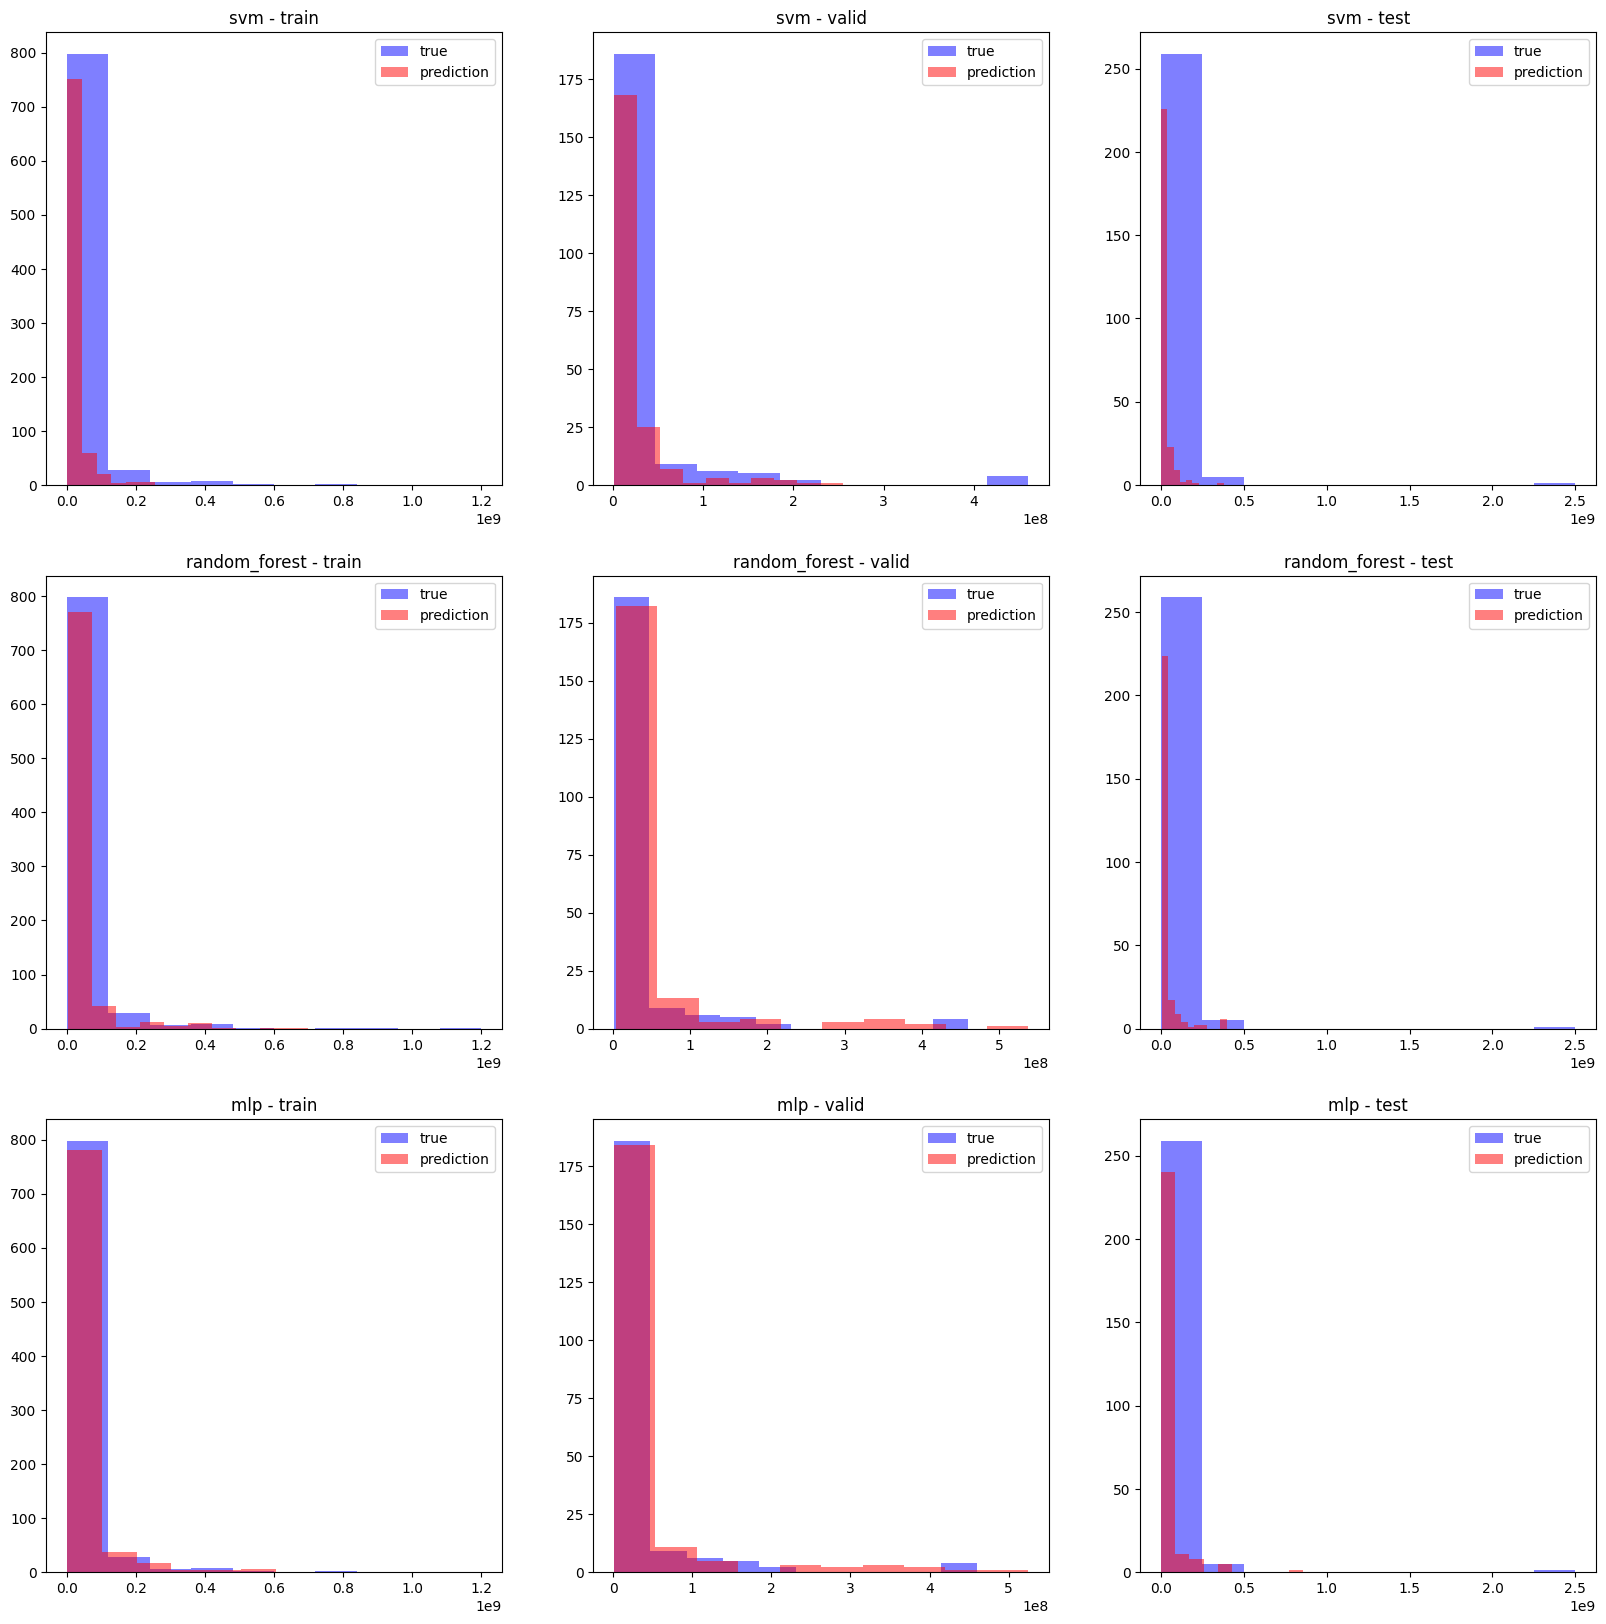

In [28]:
# Distribution visualization in normal units
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

data = [
    (X_train, y_train, 'train'), (X_valid, y_valid, 'valid'), (X_test, y_test, 'test')
]

for row, model_name in enumerate(models.keys()):
    for col, split in zip(range(3), data):
        plot_distribution(split[0], split[1], model_name, axes[row, col], split[2], loga=False)

plt.show()

d:\portfolio_projects\uti\env\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\portfolio_projects\uti\env\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\portfolio_projects\uti\env\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\portfolio_projects\uti\env\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\portfolio_projects\uti\env\lib\site-packages\sklearn\preprocessing\_encoders.

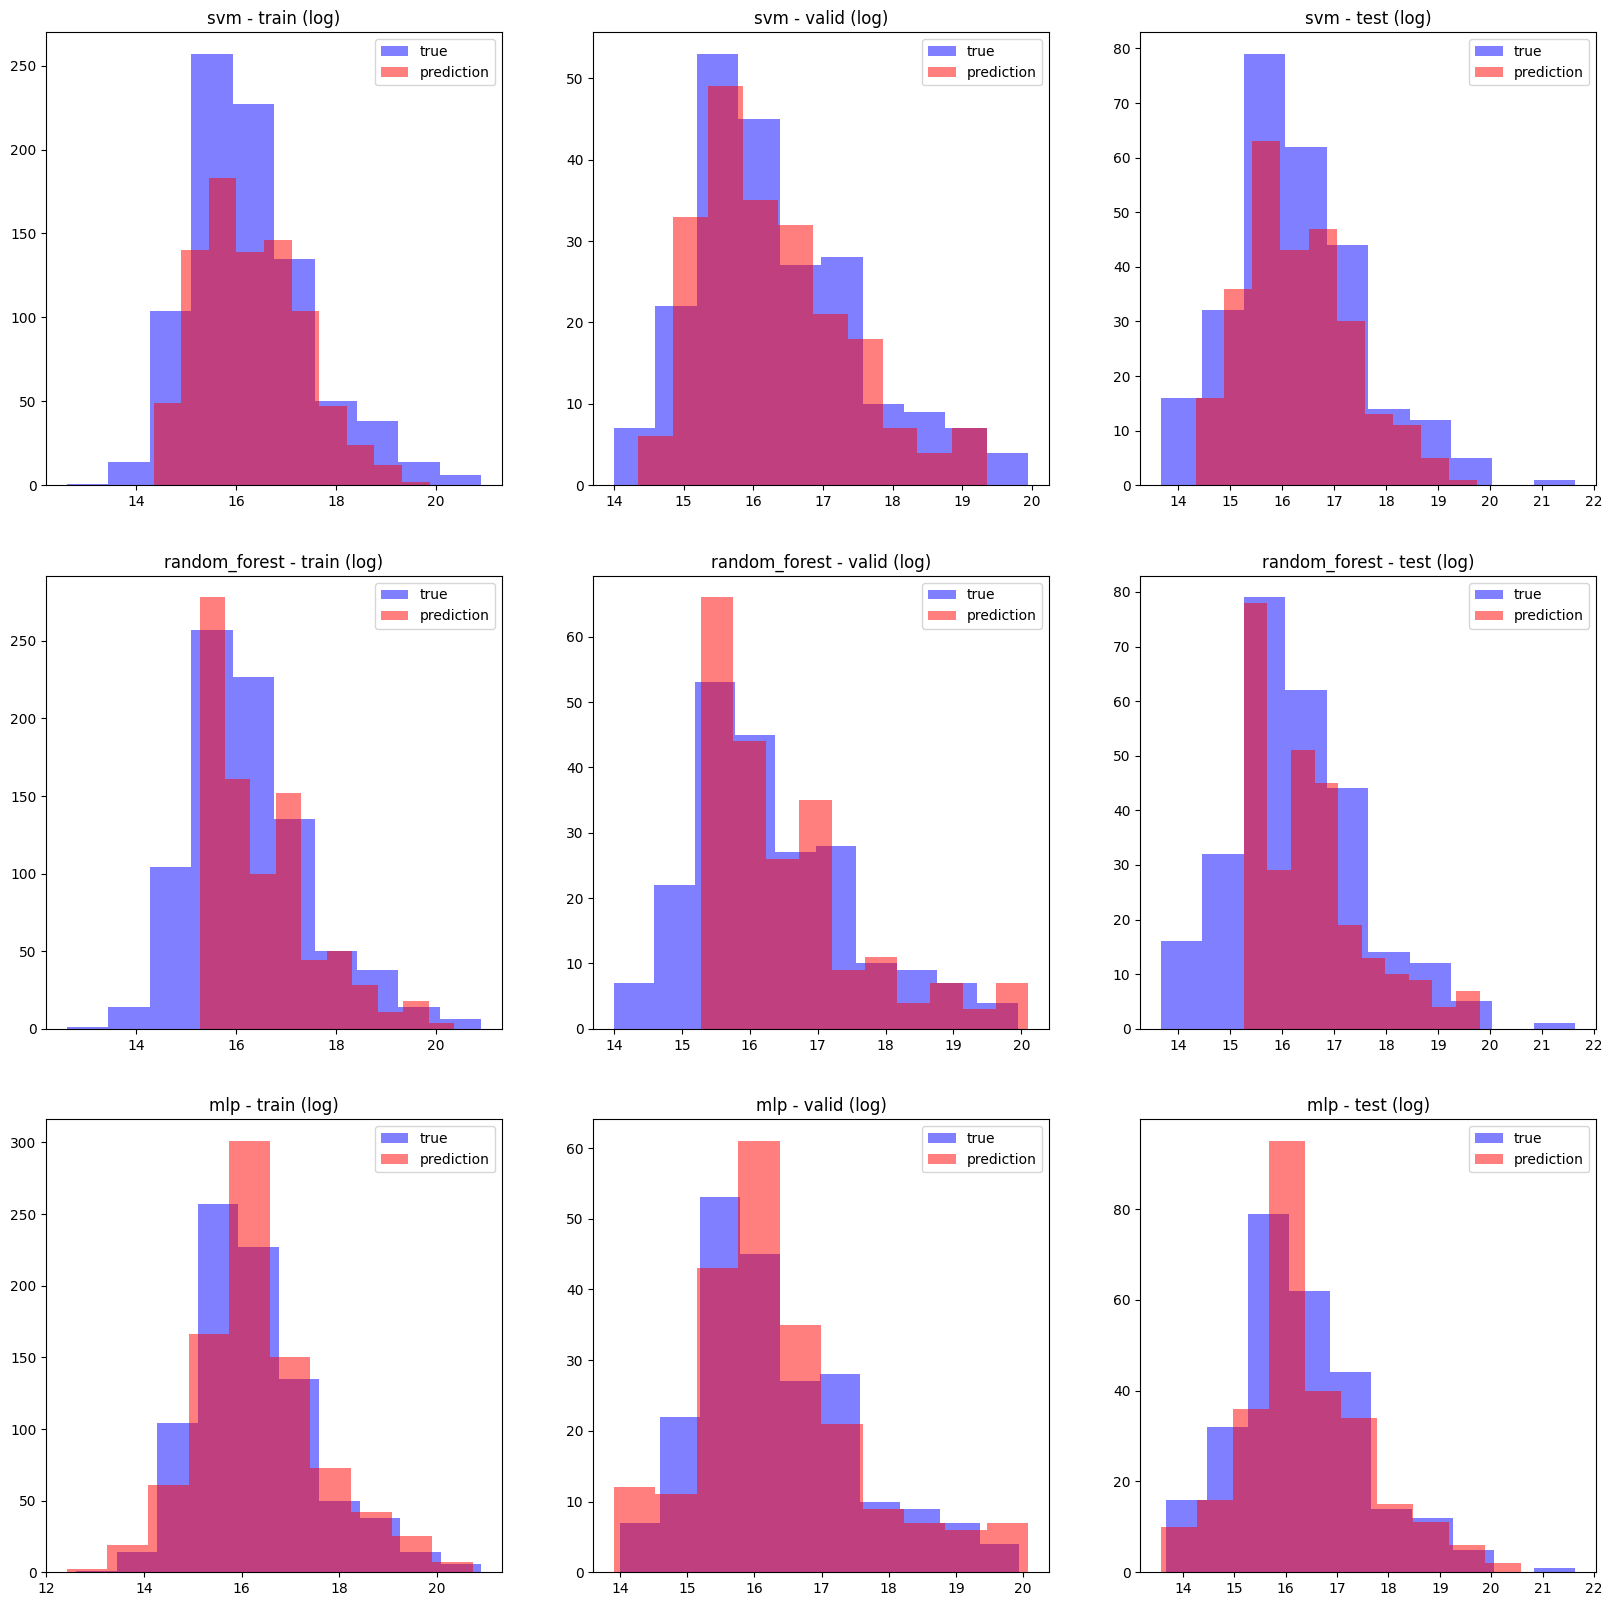

In [29]:
# Distribution visualization in log units
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for row, model_name in enumerate(models.keys()):
    for col, split in zip(range(3), data):
        plot_distribution(split[0], split[1], model_name, axes[row, col], split[2], loga=True)

plt.show()

* Based on the visualization of distributions of test targets and predictions, **MLP** seems to have the largest overlapping region with the true/target values which can be seen clearly on the log representation which further supports its MSE as the least among the three models.
* Thus, it is the best model (with its optimal parameters from hyperparamter tuning) and shall be used for deployment.

Question: Is it okay for me to perform log transformation to the target and predictions to clearly visualize the distributions? Only for the visualization to see the overlapping clearly.

# Saving the models

In [30]:
def save_model(save_path, model, model_name, version):
    try:
        filename = f"{model_name}-{version}.pkl"
        destination = os.path.join("..", save_path, filename)
        joblib.dump(model, destination)
        print(f"Saved in {destination}")
    except:
        print(f"Error saving model for {model_name}")

In [31]:
for model_name, model in model_pipelines.items():
    try:
        save_model(MODELS_PATH, model_pipelines[model_name], f'{model_name}.pkl', 'v1')
    except:
        print(f"Error saving model for {model_name}")

Saved in ..\models\svm.pkl-v1.pkl
Saved in ..\models\random_forest.pkl-v1.pkl
Saved in ..\models\mlp.pkl-v1.pkl


In [ ]:
# model_pipelines['random_forest'].predict(pd.DataFrame(X_test.iloc[0]).transpose()) # For predicting a single set of features